In [229]:
import numpy as np
import pandas as pd



In [230]:
from apply_clustering import ClusteringApplier
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from numpy.random import permutation
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

def get_feature_importances(my_feature_set, df_explainable, K=100):
    feature_combinations = []
    ([[feature_combinations.append(np.array(c)) for c in combinations(np.arange(len(my_feature_set)), i)] for i in range(1, len(my_feature_set)+1)])
    
    _, df_explainable_distances = ClusteringApplier.calculate_pairwise_distances(
        df_explainable.loc[:, my_feature_set], my_feature_set, 'correlation',
    )

    X = df_explainable.loc[:, my_feature_set].to_numpy()
    y = df_explainable_distances.to_numpy()
    model = LinearRegression()
    model.fit(X,y)
    y_pred = model.predict(X)
    R2 = explained_variance_score(y_true=y, y_pred=y_pred)
    feature_importances = defaultdict(lambda: 0.)

    i = 0
    for cols in feature_combinations:
        for k in range(K):
            permuted_X = X.copy()
            for col_i in cols:
                permuted_X[:, col_i] = permutation(permuted_X[:, col_i])
            y_pred = model.predict(permuted_X)
            feature_importances[i] += explained_variance_score(y_true=y, y_pred=y_pred)
        i += 1

    i = 0
    for cols in feature_combinations:
        feature_importances[i] = max(0, R2 - (feature_importances[i]/K))
        i += 1
        

    adj_sum = sum(feature_importances.values())
    for key, val in feature_importances.items():
        feature_importances[key] = val / adj_sum

    assert np.isclose(sum(feature_importances.values()), 1)

    def human_readable(_dict: dict) -> dict:
        return {str([str(a) for a in np.array(my_feature_set)[feature_combinations[k]]]):v for k, v in _dict.items()}
    
    human_readable_dict = human_readable(feature_importances)
    fig_1 = plt.figure(figsize=(10, 5))
    ax1 = sns.barplot(human_readable_dict)
    ax1.axes.xaxis.set_tick_params(rotation=90)

    revised_feature_importances = defaultdict(lambda: 0)
    i = 0
    for cols in feature_combinations:
            
        a = feature_importances[i]
        b = sum([feature_importances[j] for j in cols])
        revised_feature_importances[i] += a/b-1

        i += 1

    fig_2 = plt.figure(figsize=(10, 5))
    ax2 = sns.barplot(human_readable(revised_feature_importances))
    ax2.axes.xaxis.set_tick_params(rotation=90)

    return fig_1, fig_2


In [231]:
base_size = 100

In [232]:
data = np.random.normal(loc=0, scale=1, size=(base_size, 6))

In [233]:
_a = np.random.normal(loc=0.3, scale=0.1, size=(base_size, 1)).flatten()
_b = np.random.normal(loc=0.4, scale=0.1, size=(base_size, 1)).flatten()
_c1 = np.random.normal(loc=0.5, scale=0.1, size=(base_size, 1)).flatten()
_c2 = np.random.normal(loc=0.4, scale=0.2, size=(base_size, 1)).flatten()
_d1 = np.random.normal(loc=0.3, scale=0.1, size=(base_size, 1)).flatten()
_d2 = np.random.normal(loc=0.2, scale=0.05, size=(base_size, 1)).flatten()

In [234]:
a = (data[:, 0] > _a) * 1.
b = (data[:, 1] < _b) * 1.
c = np.minimum(data[:, 0] > _c1, data[:, 2] > _c2) * 1.
#d = data[:, 0] - _d1 #np.minimum(data[:, 4] > _d1, data[:, 5] < _d2) * data[:, 5]
#e = data[:, 1] * _d2 #np.minimum(data[:, 1] > _d1, data[:, 5] < _d2) * data[:, 4]

In [235]:
a.sum()/base_size, b.sum()/base_size, c.sum()/base_size, #d.sum()

(np.float64(0.41), np.float64(0.68), np.float64(0.08))

In [236]:
df_explainable = pd.DataFrame(data)
df_explainable.head()

,0,1,2,3,4,5
0,1.567765,-1.023232,-2.262266,-0.540556,-1.189945,1.502839
1,-1.355540,0.592393,-0.596901,-1.186498,0.169692,-2.171906
2,0.039668,-1.457649,0.115186,-0.302341,-0.783655,-1.033010
3,0.326525,1.089033,0.515622,-1.756389,-1.304507,1.872050
4,-1.655912,0.032319,-1.118991,-1.489180,-0.432212,-1.027397


In [237]:
explaining_features = list(df_explainable.columns)

In [238]:
df_observable = pd.DataFrame({
    'a': a,
    'b': b,
    'c': c,
    #'d': d,
    #'e': e
})
observed_features = list(df_observable.columns)

In [239]:
df_observable.head()

,a,b,c
0,1.0,1.0,0.0
1,0.0,0.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0


In [240]:
df_observable = df_observable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
df_explainable = df_explainable.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

In [241]:
df_explainable.loc[:, 'Index'] = df_explainable.index
df_observable.loc[:, 'Index'] = df_observable.index

index_name = 'Index'

[6, np.int64(2)]


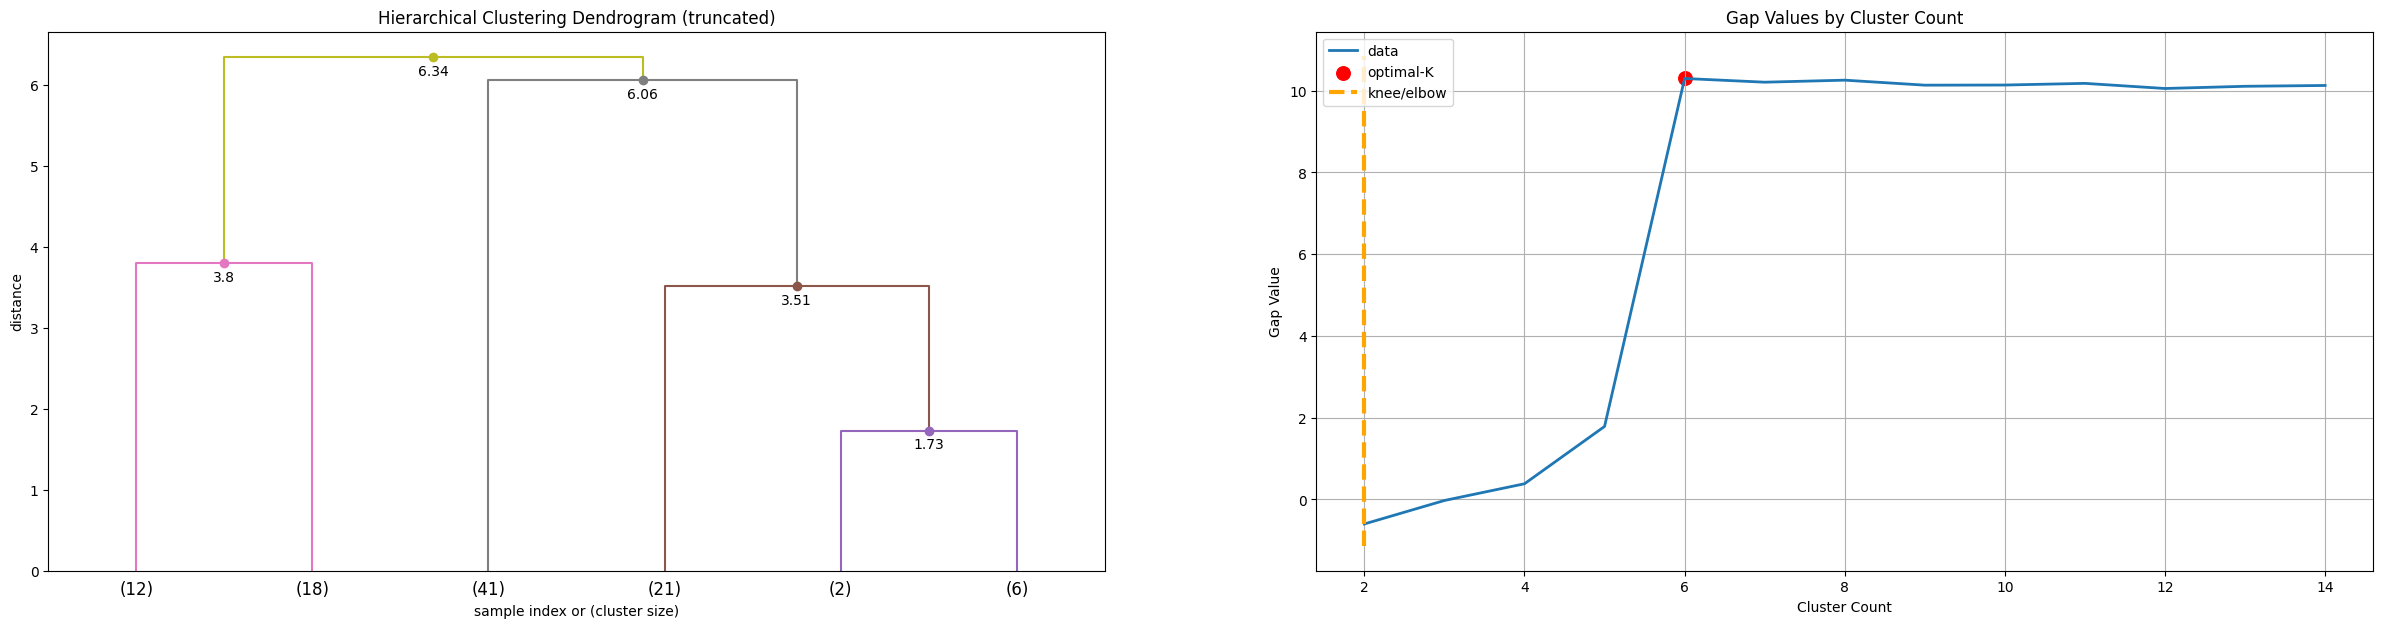

In [242]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

preparation_result = DataPreparator.prepare_data(
    use_config=False,
    df_observable=df_observable,
    df_explainable=df_explainable,
    distortion_mean=0.,
    distortion_std=0.001,
    observed_features=observed_features,
    explaining_features=explaining_features,
    nn_imputation_k=10,
    group_name=index_name
)
optimal_number_of_clusters = ClusteringApplier.draw_gap_statistic_plot(
    use_config=False, df_observable=preparation_result['observable_df'],
    observed_features=observed_features,
    gap_statistic_cluster_range=15
)
print(optimal_number_of_clusters)

  0%|          | 0/57 [00:00<?, ?it/s]

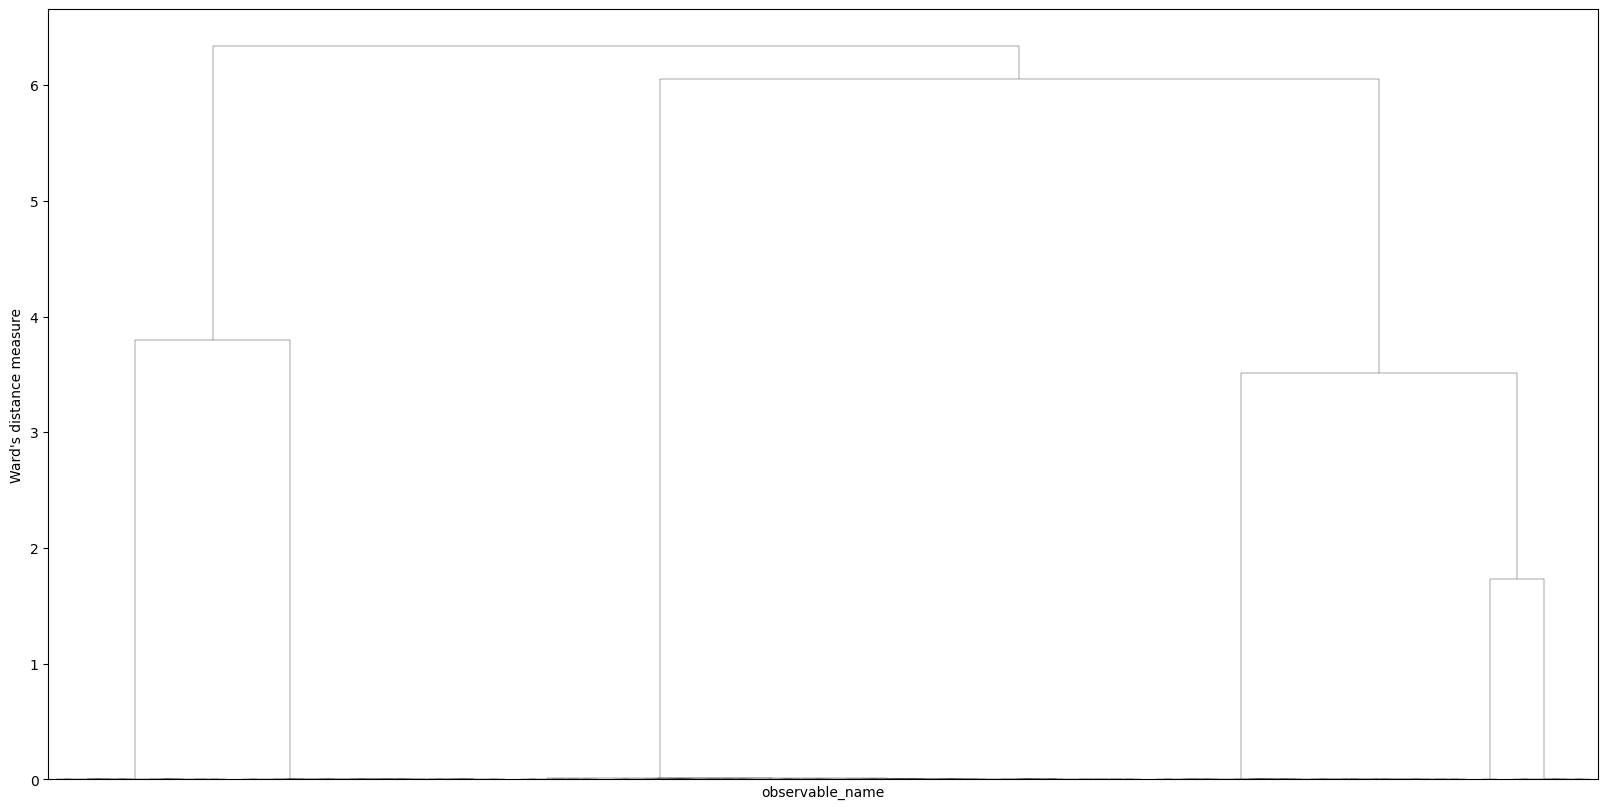

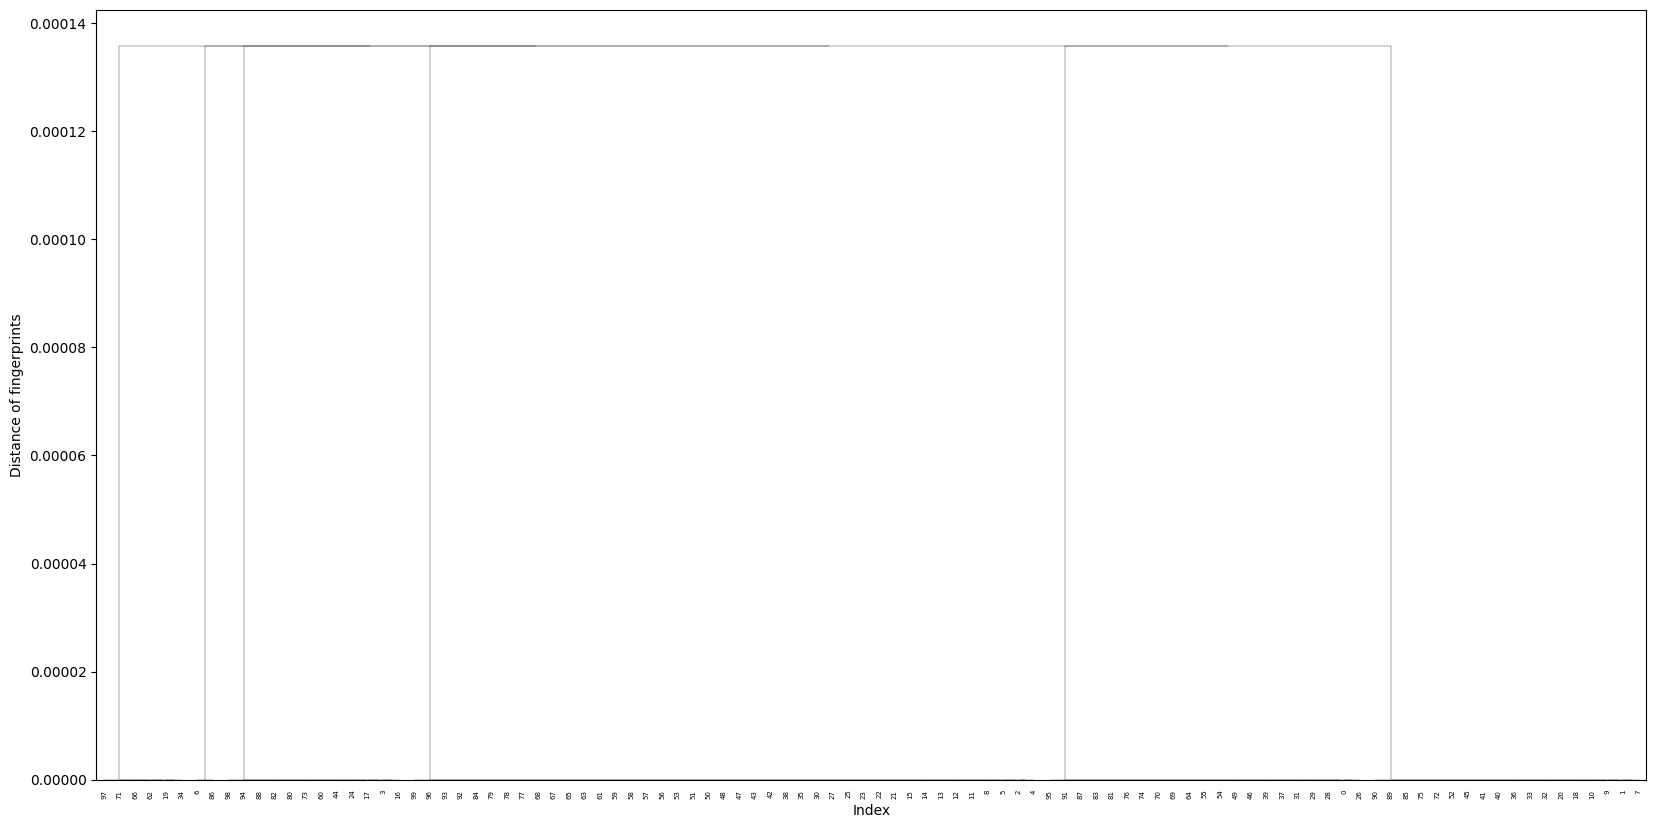

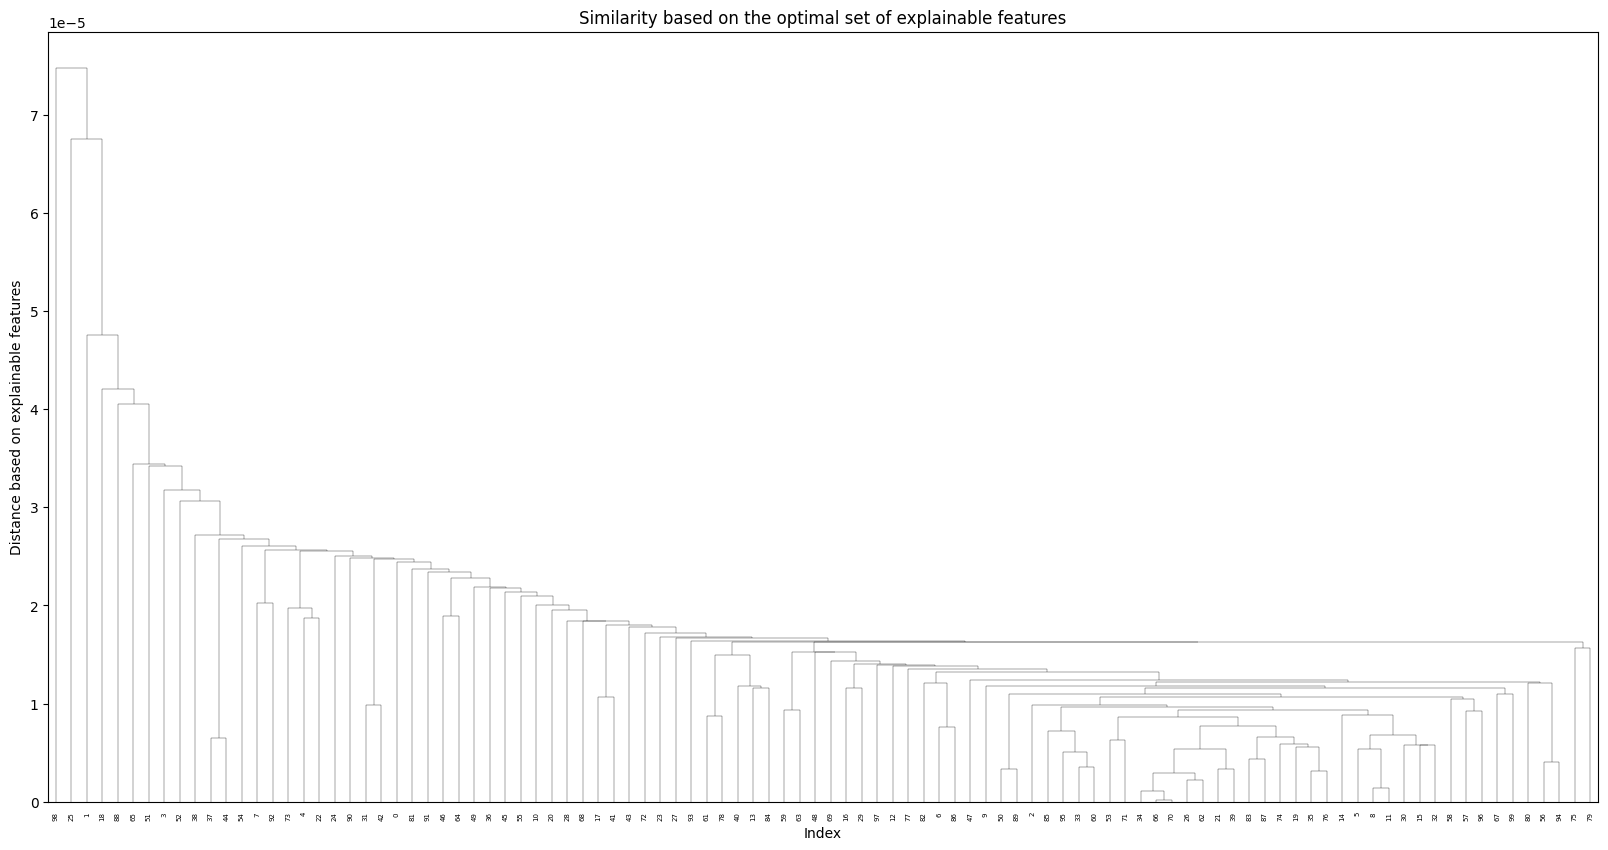

In [243]:
my_number_of_clusters = optimal_number_of_clusters[0] #max(3, optimal_number_of_clusters)
observable_patterns_result = ClusteringApplier.calculate_observable_patterns(
    use_config=False,
    df_observable_data=preparation_result['observable_df'],
    _n_clusters=my_number_of_clusters,
    observable_name='observable_name',
    observable_feature_names=observed_features,
    plot_title='Name of the fingerprint plot',
    number_observable_patterns='auto',
    distance_measure_fingerprint='jensenshannon',
    group_name=index_name, 
)
calculate_explainable_distances_result = ClusteringApplier.calculate_explainable_distances(
    use_config=False,
    df_explainable=preparation_result['explainable_df'].copy(),
    df_observable_distances=observable_patterns_result['pw_norm_dist'].copy(),
    explaining_features=explaining_features,
    method='exact',
    distance_measure='correlation',
    sparsity_parameter=0.01,
    max_num_threads=12,
    group_name=index_name
)

In [244]:
optimal_number_of_clusters

[6, np.int64(2)]

In [245]:
observable_patterns_result['spider_plots']

In [246]:
preparation_result['observable_scaling']

,feature,scaling
0,a,1.0
1,b,1.0
2,c,1.0


In [247]:
calculate_explainable_distances_result.keys()

dict_keys(['overview_df', 'df_explainable_distances', 'dendrogram', 'optimal_feature_set'])

In [248]:
observable_patterns_result.keys()

dict_keys(['df_cluster_median', 'df_observable_data', 'df_fingerprint', 'pw_dist', 'pw_norm_dist', 'spider_plots', 'fingerprint_distance_plots'])

In [249]:
calculate_explainable_distances_result['optimal_feature_set']

[0, 1, 3, 4]

In [250]:
calculate_explainable_distances_result['overview_df']

,correlation,0,1,2,3,4,5
0,0.17275,1,1,0,1,1,0


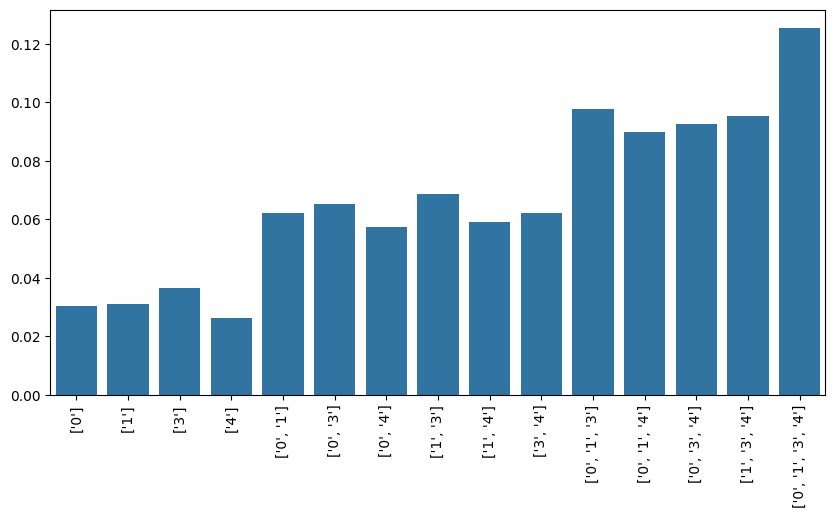

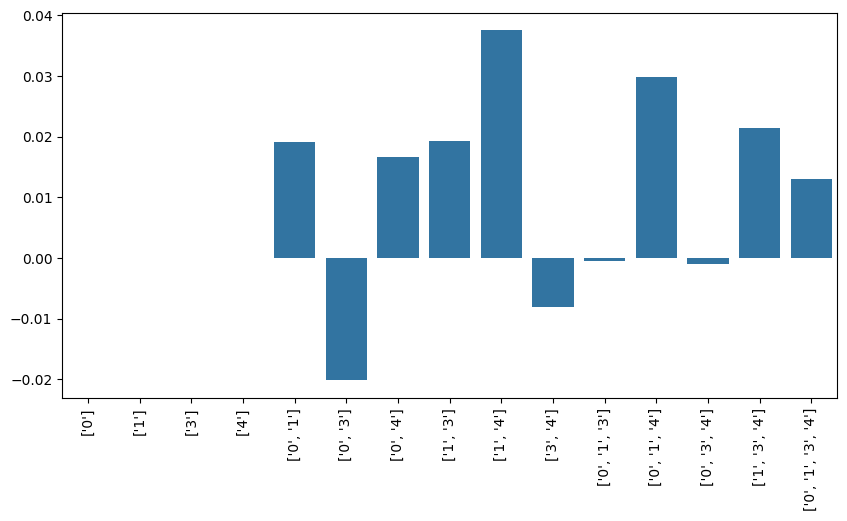

In [251]:
fig_1, fig_2 = get_feature_importances(
    my_feature_set=explaining_features, #calculate_explainable_distances_result['optimal_feature_set'],
    df_explainable=preparation_result['explainable_df']
)

In [228]:
...

Ellipsis

In [257]:
def foo(df_observable, df_explainable, my_feature_set, group_name, K=100):
    obs_df = df_observable.reset_index()
    idx = obs_df.index
    y = df_observable.reset_index().groupby(group_name).mean().to_numpy()
    get_y = lambda: obs_df.loc[permutation(idx)].drop_duplicates(subset=[group_name], keep='first').set_index(group_name).loc[df_explainable.index].to_numpy()

    model = LinearRegression()
    X = df_explainable.loc[:, my_feature_set].to_numpy()
    model.fit(X,y)
    y_pred = model.predict(X)
    R2 = explained_variance_score(y_true=y, y_pred=y_pred)

    feature_importances = defaultdict(lambda: 0.)
    for col_i in range(X.shape[1]):
        for k in range(K):
            permuted_X = X.copy()
            permuted_X[:, col_i] = permutation(permuted_X[:, col_i])
            y = get_y()
            model.fit(X,y)
            R2 = explained_variance_score(y_true=y, y_pred=model.predict(X))
            y_pred = model.predict(permuted_X)
            feature_importances[my_feature_set[col_i]] += (R2 - explained_variance_score(y_true=y, y_pred=y_pred))/K

    adj_sum = sum(feature_importances.values())
    for key, val in feature_importances.items():
        feature_importances[key] = val / adj_sum

    assert np.isclose(sum(feature_importances.values()), 1)

    return feature_importances

<Axes: >

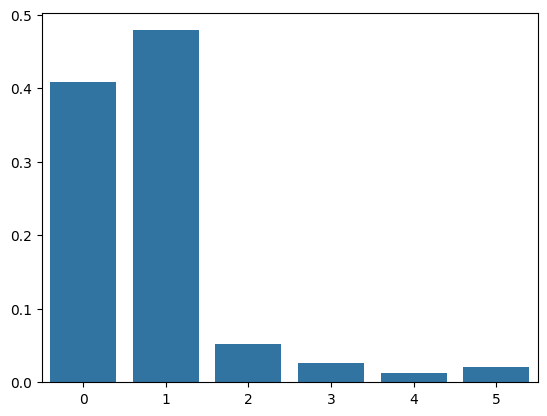

In [259]:
res = foo(preparation_result['observable_df'], preparation_result['explainable_df'], explaining_features, group_name='Index')
sns.barplot(res)